# Models

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
%run Mappings.ipynb

In [3]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
DIR = ''

In [4]:
data = pd.read_csv(DIR+'dataset/final_data.csv')

In [5]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Metrics

In [6]:
def get_metrics(y_true, prediction):
    recall = round(recall_score(y_true, prediction), 4)
    accuracy = round(accuracy_score(y_true, prediction), 4)
    precision = round(precision_score(y_true, prediction), 4)
    roc_auc = round(roc_auc_score(y_true, prediction), 4) 
    f1 = round(f1_score(y_true, prediction), 4)
    conf_matrix = confusion_matrix(y_true, prediction).flatten()
    
    '''
    print('Test recall:\t', str(recall))
    print('Test accuracy:\t', str(accuracy))
    print('Test precision:\t', str(precision))
    print('Test ROC AUC:\t', str(roc_auc))
    print('Test F1 score:\t', str(f1))
    print('Test confusion matrix:\t'+ str(conf_matrix))
    '''
    return recall, accuracy, precision, roc_auc, f1, conf_matrix

## Logit

In [7]:
class SMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        yhat = self.results_.predict(X)
        return list(map(round, yhat))

In [8]:
def perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col):
    X_train_df = pd.DataFrame(data=X_train, columns=X_cols)
    y_train_df = pd.DataFrame(data=y_train, columns=y_col)
    logit_model = SMWrapper(sm.Logit)
    scores = cross_val_score(logit_model, X_train_df, y_train_df, scoring='recall', cv=5, n_jobs=-1)
    val_score = round(np.nanmean(scores), 4)
    print('Mean cross-validation score: ')
    print(val_score)
    X_train_df = sm.add_constant(X_train_df)
    logit = Logit(y_train_df, X_train_df)
    lg = logit.fit()
    #print(lg.summary())
    X_test = sm.add_constant(X_test)
    yhat = lg.predict(X_test)
    prediction = list(map(round, yhat))
    return val_score, get_metrics(y_test, prediction)

## Random forest

In [9]:
def perform_random_forest(X_train, y_train, X_test, y_test):
    #hyperparameters config
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 15)]
    criterion = ['gini', 'entropy']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #grid search config
    rf_scoring='recall'
    rf_cv = 5
    rf_verbose=1
    rf_n_jobs=-1
    rf_return_train_score=True
    rf = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            scoring=rf_scoring, cv=rf_cv, 
                            verbose=rf_verbose, n_jobs=rf_n_jobs, 
                            return_train_score=rf_return_train_score)
    start_time = time.time()
    rf_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    print('Mean cross-validation score of best model: ')
    val_score = round(rf_grid.best_score_, 4)
    print(val_score)
    print('Best parameters:')
    pprint(rf_grid.best_params_)

    rf.set_params(bootstrap = rf_grid.best_params_['bootstrap'], 
                    criterion = rf_grid.best_params_['criterion'], 
                    max_depth = rf_grid.best_params_['max_depth'],
                    max_features = rf_grid.best_params_['max_features'],
                    min_samples_leaf = rf_grid.best_params_['min_samples_leaf'],
                    min_samples_split = rf_grid.best_params_['min_samples_split'],
                    n_estimators = rf_grid.best_params_['n_estimators'])
    rf.fit(X_train, y_train)
    prediction = rf.predict(X_test)
    pprint(rf.get_params())
    metrics = get_metrics(y_test, prediction)
    
    start_time = time.time()
    importances = rf_grid.best_estimator_.feature_importances_
    std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: " 
          f"{elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=X_cols).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return val_score, metrics

## Decision trees

In [10]:
def perform_decision_tree(X_train, y_train, X_test, y_test):
    #hyperparameters config
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 50, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    search_grid = {'criterion': criterion,
                   'splitter': splitter,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    #grid search config
    dtc_scoring='recall'
    dtc_cv = 5
    dtc_verbose=1
    dtc_n_jobs=-1
    dtc_return_train_score=True
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, 
                            param_grid=search_grid,
                            scoring=dtc_scoring, cv=dtc_cv, 
                            verbose=dtc_verbose, n_jobs=dtc_n_jobs, 
                            return_train_score=dtc_return_train_score)
    start_time = time.time()
    dtc_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    print('Mean cross-validation score of best model: ')
    val_score = round(dtc_grid.best_score_, 4)
    print(val_score)
    print('Best parameters:')
    pprint(dtc_grid.best_params_)
    
    dtc = DecisionTreeClassifier()
    dtc.set_params(criterion = dtc_grid.best_params_['criterion'], 
                   max_depth = dtc_grid.best_params_['max_depth'],
                    max_features = dtc_grid.best_params_['max_features'],
                    min_samples_leaf = dtc_grid.best_params_['min_samples_leaf'],
                    min_samples_split = dtc_grid.best_params_['min_samples_split'],
                    splitter = dtc_grid.best_params_['splitter'])
    dtc.fit(X_train, y_train)
    prediction = dtc.predict(X_test)
    pprint(dtc.get_params())
    return val_score, get_metrics(y_test, prediction)

# Data preparation 

In [16]:
print(data.shape[0])
data_dropped = data.dropna()
print(data_dropped.shape[0])
data_train, data_test = train_test_split(data_dropped, test_size=400, random_state=42)
print(data_train.shape[0])
print(data_test.shape[0])
data_test_mapped = perform_mapping(data_test, questions_map_EN)
X_test = data_test.drop(columns=['Que16']).to_numpy()
y_test = data_test['Que16'].to_numpy()
print(np.unique(y_test, return_counts=True))
index_to_remove = data_test.index.to_numpy()
data_remain = data.drop(index_to_remove)
#strategy 1
data_dropped = data_remain.dropna().reset_index(drop=True)
data_dropped = perform_mapping(data_dropped, questions_map_EN)
#strategy 2
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_median = pd.DataFrame(imputer.fit_transform(data_remain))
data_median.columns = data_remain.columns
data_median.index = data_remain.index
data_median = perform_mapping(data_median, questions_map_EN)
#strategy 3
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean = pd.DataFrame(imputer.fit_transform(data_remain))
data_mean.columns = data_remain.columns
data_mean.index = data_remain.index
# mean values are not integer numbers so rounding to int was necessary
data_mean = data_mean.round()
data_mean = perform_mapping(data_mean, questions_map_EN)
#strategy 4
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_most_frequent = pd.DataFrame(imputer.fit_transform(data_remain))
data_most_frequent.columns = data_remain.columns
data_most_frequent.index = data_remain.index
data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)

4310
936
536
400
(array([0., 1.]), array([138, 262]))


In [17]:
def get_strategy_data(strategy=None):
    if strategy=='strategy1':
        X_train = data_dropped.drop(columns=['Que16']).to_numpy()
        y_train = data_dropped['Que16'].to_numpy()
    elif strategy=='strategy2':
        X_train = data_median.drop(columns=['Que16']).to_numpy()
        y_train = data_median['Que16'].to_numpy()
    elif strategy=='strategy3':
        X_train = data_mean.drop(columns=['Que16']).to_numpy()
        y_train = data_mean['Que16'].to_numpy()
    elif strategy=='strategy4':
        X_train = data_most_frequent.drop(columns=['Que16']).to_numpy()
        y_train = data_most_frequent['Que16'].to_numpy()
    else:
        X_train = None
        y_train = None
    return X_train, y_train

def get_balanced_data(X_train, y_train, balance=None):
    if balance=='no_balance':
        X_balanced = X_train
        y_balanced = y_train
    elif balance=='under':
        rus = RandomUnderSampler(random_state=0)
        X_balanced, y_balanced = rus.fit_resample(X_train, y_train)
    elif balance=='over':
        ros = RandomOverSampler(random_state=0)
        X_balanced, y_balanced = ros.fit_resample(X_train, y_train)
    elif balance=='smoteenn':
        smote_enn = SMOTEENN(random_state=0)
        X_balanced, y_balanced = smote_enn.fit_resample(X_train, y_train)
    else:
        X_balanced = None
        y_balanced = None
    return X_balanced, y_balanced

In [20]:
cols = ['model', 'strategy', 'balance', 'val_score', 'recall', 'accuracy', 'precision', 'roc_auc', 'f1-score', 'conf matrix']
key = 0
dict_metric = {}
for model in ['log_reg']:
    for strategy in ['strategy1', 'strategy2', 'strategy3', 'strategy4']:
        for balance in ['no_balance', 'under', 'over', 'smoteenn']:
            dict_metric[key] = []
            dict_metric[key].extend([model, strategy, balance])
            X_train, y_train = get_strategy_data(strategy)
            X_train, y_train = get_balanced_data(X_train, y_train, balance)
            
            try:
                if model=='log_reg':
                    metrics = perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5]])
                elif model=='dec_tree':
                    metrics = perform_decision_tree(X_train, y_train, X_test, y_test)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5]])
                elif model=='rand_for':
                    metrics = perform_random_forest(X_train, y_train, X_test, y_test)
                    dict_metric[key].extend([metrics[0], metrics[1][0], metrics[1][1], metrics[1][2], metrics[1][3], metrics[1][4], metrics[1][5]])
                else:
                    print('Not existing model!')
                key+=1
            except:
                dict_metric[key].extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
                key+=1
                continue
pd.DataFrame.from_dict(dict_metric, orient='index', columns=cols)

Mean cross-validation score: 
0.6985
Optimization terminated successfully.
         Current function value: 0.561771
         Iterations 7
Mean cross-validation score: 
0.622
Optimization terminated successfully.
         Current function value: 0.582424
         Iterations 7
Mean cross-validation score: 
0.5284
Optimization terminated successfully.
         Current function value: 0.572383
         Iterations 6


/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Mean cross-validation score: 
nan
         Current function value: 0.274152
         Iterations: 35
Mean cross-validation score: 
0.8046
Optimization terminated successfully.
         Current function value: 0.548002
         Iterations 6
Mean cross-validation score: 
0.6629
Optimization terminated successfully.
         Current function value: 0.606006
         Iterations 6
Mean cross-validation score: 
0.5694
Optimization terminated successfully.
         Current function value: 0.603337
         Iterations 6
Mean cross-validation score: 
0.7205
Optimization terminated successfully.
         Current function value: 0.426507
         Iterations 6
Mean cross-validation score: 
0.7827
Optimization terminated successfully.
         Current function value: 0.543508
         Iterations 6
Mean cross-validation score: 
0.6637
Optimization terminated successfully.
         Current function value: 0.599465
         Iterations 6
Mean cross-validation score: 
0.5661
Optimization terminated succe

,model,strategy,balance,val_score,recall,accuracy,precision,roc_auc,f1-score,conf matrix
0,log_reg,strategy1,no_balance,0.6985,0.7595,0.6850,0.7595,0.6515,0.7595,"[75, 63, 63, 199]"
1,log_reg,strategy1,under,0.6220,0.6260,0.6350,0.7736,0.6391,0.6920,"[90, 48, 98, 164]"
2,log_reg,strategy1,over,0.5284,0.6374,0.6600,0.8029,0.6702,0.7106,"[97, 41, 95, 167]"
3,log_reg,strategy1,smoteenn,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,log_reg,strategy2,no_balance,0.8046,0.8550,0.6725,0.7066,0.5905,0.7737,"[45, 93, 38, 224]"
5,log_reg,strategy2,under,0.6629,0.5840,0.6425,0.8182,0.6688,0.6815,"[104, 34, 109, 153]"
6,log_reg,strategy2,over,0.5694,0.5878,0.6450,0.8191,0.6707,0.6844,"[104, 34, 108, 154]"
7,log_reg,strategy2,smoteenn,0.7205,0.5153,0.6125,0.8282,0.6562,0.6353,"[110, 28, 127, 135]"
8,log_reg,strategy3,no_balance,0.7827,0.8435,0.6700,0.7083,0.5920,0.7700,"[47, 91, 41, 221]"
9,log_reg,strategy3,under,0.6637,0.5878,0.6425,0.8148,0.6671,0.6829,"[103, 35, 108, 154]"


# Strategy 1 - dropping all missing

In [12]:
X_train = data_dropped.drop(columns=['Que16']).to_numpy()
y_train = data_dropped['Que16'].to_numpy()
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [13]:
dict_metric[key] = []
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6985
Optimization terminated successfully.
         Current function value: 0.561771
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  536
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1508
Time:                        23:48:59   Log-Likelihood:                -301.11
converged:                       True   LL-Null:                       -354.60
Covariance Type:            nonrobust   LLR p-value:                 1.649e-13
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9645      0.339     -2.847      0.004      -1.628  

### Undersampling

In [14]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.622
Optimization terminated successfully.
         Current function value: 0.582424
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  402
Model:                          Logit   Df Residuals:                      380
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1597
Time:                        23:49:00   Log-Likelihood:                -234.13
converged:                       True   LL-Null:                       -278.65
Covariance Type:            nonrobust   LLR p-value:                 2.380e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4574      0.394     -3.697      0.000      -2.230   

### Oversampling

In [15]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.5284
Optimization terminated successfully.
         Current function value: 0.572383
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  670
Model:                          Logit   Df Residuals:                      648
Method:                           MLE   Df Model:                           21
Date:                Thu, 02 Sep 2021   Pseudo R-squ.:                  0.1742
Time:                        23:49:00   Log-Likelihood:                -383.50
converged:                       True   LL-Null:                       -464.41
Covariance Type:            nonrobust   LLR p-value:                 9.676e-24
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5508      0.311     -4.991      0.000      -2.160  

### SMOTEENN

In [16]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
nan
         Current function value: 0.274152
         Iterations: 35


/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


LinAlgError: Singular matrix

## Random Forest

### No balance

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:15:35.578428
Mean cross-validation score of best model: 
0.8523
Best parameters:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 25}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 21,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.8015
Test accuracy:	 0.6575
Test precision:	 0.7119
Test ROC AUC:	 0.5928
Test F1 score:	 0.754
Test confusion matrix:	
[[ 53  85]
 [ 52 210]]
Elapsed time to compute the importances:

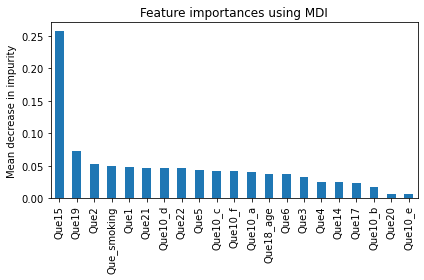

In [18]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:12:43.801169
Mean cross-validation score of best model: 
0.7062
Best parameters:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 77}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 77,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6069
Test accuracy:	 0.65
Test precision:	 0.8112
Test ROC AUC:	 0.6694
Test F1 score:	 0.6943
Test confusion matrix:	
[[101  37]
 [103 159]]
Elapsed time to compute the importances: 

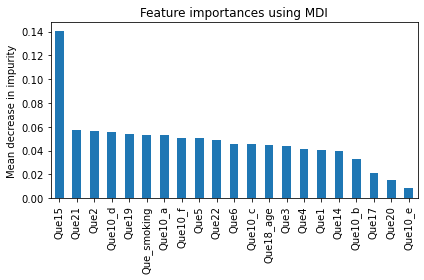

In [19]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:18:35.771527
Mean cross-validation score of best model: 
0.6211
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 77}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 77,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7099
Test accuracy:	 0.6475
Test precision:	 0.741
Test ROC AUC:	 0.6195
Test F1 score:	 0.7251
Test confusion matrix:	
[[ 73  65]
 [ 76 186]]
Elapsed time to compute the importances: 0.648

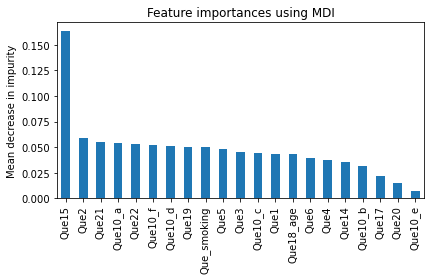

In [20]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:12:39.591316
Mean cross-validation score of best model: 
0.8475
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 43,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 5}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 43,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5229
Test accuracy:	 0.61
Test precision:	 0.8155
Test ROC AUC:	 0.6491
Test F1 score:	 0.6372
Test confusion matrix:	
[[107  31]
 [125 137]]
Elapsed time to compute the importances: 0.004 se

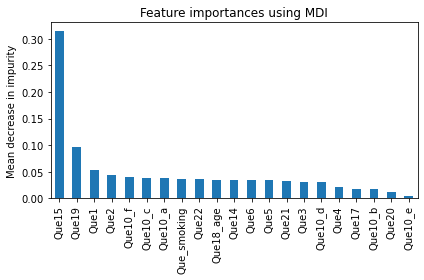

In [21]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [22]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.452231
Mean cross-validation score of best model: 
0.7883
Best parameters:
{'criterion': 'entropy',
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 26,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7366
Test accuracy:	 0.635
Test precision:	 0.7148
Test ROC AUC:	 0.5893
Test F1 score:	 0.7256
Test confusion matrix:	
[[ 61  77]
 [ 69 193]]


### Undersampling

In [23]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:01.844531
Mean cross-validation score of best model: 
0.6571
Best parameters:
{'criterion': 'entropy',
 'max_depth': 34,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 34,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5115
Test accuracy:	 0.57
Test precision:	 0.7528
Test ROC AUC:	 0.5963
Test F1 score:	 0.6091
Test confusion matrix:	
[[ 94  44]
 [128 134]]


### Oversampling

In [24]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.808934
Mean cross-validation score of best model: 
0.6153
Best parameters:
{'criterion': 'entropy',
 'max_depth': 34,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 34,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6374
Test accuracy:	 0.615
Test precision:	 0.7389
Test ROC AUC:	 0.6049
Test F1 score:	 0.6844
Test confusion matrix:	
[[ 79  59]
 [ 95 167]]


### SMOTEENN

In [25]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.041513
Mean cross-validation score of best model: 
0.8056
Best parameters:
{'criterion': 'entropy',
 'max_depth': 42,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 42,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5534
Test accuracy:	 0.6
Test precision:	 0.7713
Test ROC AUC:	 0.6209
Test F1 score:	 0.6444
Test confusion matrix:	
[[ 95  43]
 [117 145]]


# Strategy 2 - median

In [26]:
X_train = data_median.drop(columns=['Que16']).to_numpy()
y_train = data_median['Que16'].to_numpy()
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [27]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8046
Optimization terminated successfully.
         Current function value: 0.548002
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3910
Model:                          Logit   Df Residuals:                     3888
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1177
Time:                        00:49:03   Log-Likelihood:                -2142.7
converged:                       True   LL-Null:                       -2428.5
Covariance Type:            nonrobust   LLR p-value:                1.402e-107
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5347      0.128     -4.165      0.000      -0.786  

### Undersampling

In [28]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6629
Optimization terminated successfully.
         Current function value: 0.606006
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2444
Model:                          Logit   Df Residuals:                     2422
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1257
Time:                        00:49:03   Log-Likelihood:                -1481.1
converged:                       True   LL-Null:                       -1694.1
Covariance Type:            nonrobust   LLR p-value:                 3.904e-77
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2662      0.158     -8.016      0.000      -1.576  

### Oversampling

In [29]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.5694
Optimization terminated successfully.
         Current function value: 0.603337
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 5376
Model:                          Logit   Df Residuals:                     5354
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1296
Time:                        00:49:04   Log-Likelihood:                -3243.5
converged:                       True   LL-Null:                       -3726.4
Covariance Type:            nonrobust   LLR p-value:                5.827e-191
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3105      0.108    -12.190      0.000      -1.521  

### SMOTEENN

In [30]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.7205
Optimization terminated successfully.
         Current function value: 0.426507
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2855
Model:                          Logit   Df Residuals:                     2833
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.3718
Time:                        00:49:04   Log-Likelihood:                -1217.7
converged:                       True   LL-Null:                       -1938.2
Covariance Type:            nonrobust   LLR p-value:                1.481e-292
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.7335      0.221    -16.910      0.000      -4.166  

## Random Forest

### No balance

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:14:37.241736
Mean cross-validation score of best model: 
0.872
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 77}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 77,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.855
Test accuracy:	 0.68
Test precision:	 0.7134
Test ROC AUC:	 0.6014
Test F1 score:	 0.7778
Test confusion matrix:	
[[ 48  90]
 [ 38 224]]
Elapsed time to compute the importances: 0.546 

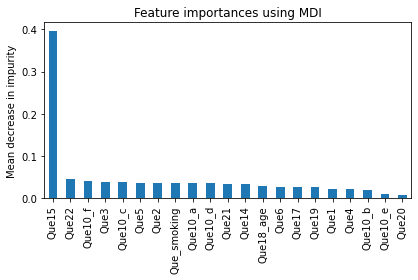

In [31]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:11:42.369351
Mean cross-validation score of best model: 
0.7005
Best parameters:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 118}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 65,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 118,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.645
Test accuracy:	 0.6525
Test precision:	 0.786
Test ROC AUC:	 0.6559
Test F1 score:	 0.7086
Test confusion matrix:	
[[ 92  46]
 [ 93 169]]
Elapsed time to compute the importances

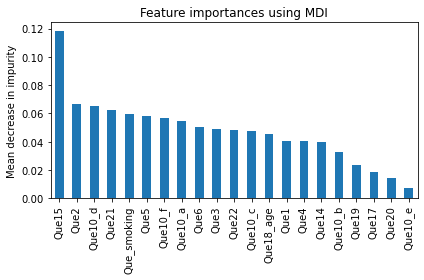

In [32]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:17:36.446020
Mean cross-validation score of best model: 
0.5948
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7366
Test accuracy:	 0.6625
Test precision:	 0.7452
Test ROC AUC:	 0.6292
Test F1 score:	 0.7409
Test confusion matrix:	
[[ 72  66]
 [ 69 193]]
Elapsed time to compute the importances: 0.07

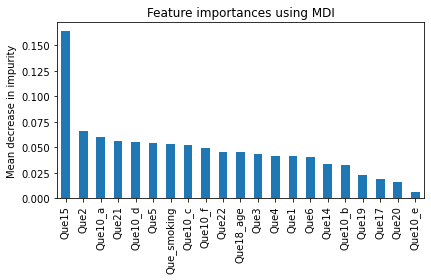

In [33]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:12:27.600261
Mean cross-validation score of best model: 
0.8662
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 77}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 77,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6069
Test accuracy:	 0.6575
Test precision:	 0.8238
Test ROC AUC:	 0.6802
Test F1 score:	 0.6989
Test confusion matrix:	
[[104  34]
 [103 159]]
Elapsed time to compute the importances: 0.58

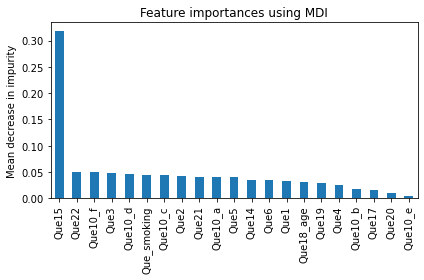

In [34]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [35]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.442574
Mean cross-validation score of best model: 
0.814
Best parameters:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7824
Test accuracy:	 0.6925
Test precision:	 0.7565
Test ROC AUC:	 0.6521
Test F1 score:	 0.7692
Test confusion matrix:	
[[ 72  66]
 [ 57 205]]


### Undersampling

In [36]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:01.822555
Mean cross-validation score of best model: 
0.6595
Best parameters:
{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5763
Test accuracy:	 0.5875
Test precision:	 0.7366
Test ROC AUC:	 0.5925
Test F1 score:	 0.6467
Test confusion matrix:	
[[ 84  54]
 [111 151]]


### Oversampling

In [37]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.860071
Mean cross-validation score of best model: 
0.6008
Best parameters:
{'criterion': 'gini',
 'max_depth': 42,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 42,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6565
Test accuracy:	 0.63
Test precision:	 0.7478
Test ROC AUC:	 0.6181
Test F1 score:	 0.6992
Test confusion matrix:	
[[ 80  58]
 [ 90 172]]


### SMOTEENN

In [38]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.006855
Mean cross-validation score of best model: 
0.8375
Best parameters:
{'criterion': 'entropy',
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 26,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6145
Test accuracy:	 0.655
Test precision:	 0.8131
Test ROC AUC:	 0.6732
Test F1 score:	 0.7
Test confusion matrix:	
[[101  37]
 [101 161]]


# Strategy 3 - mean

In [39]:
X_train = data_mean.drop(columns=['Que16']).to_numpy()
y_train = data_mean['Que16'].to_numpy()
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [40]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.7827
Optimization terminated successfully.
         Current function value: 0.543508
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3910
Model:                          Logit   Df Residuals:                     3888
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1249
Time:                        01:45:42   Log-Likelihood:                -2125.1
converged:                       True   LL-Null:                       -2428.5
Covariance Type:            nonrobust   LLR p-value:                5.765e-115
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4621      0.125     -3.695      0.000      -0.707  

### Undersampling

In [41]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6637
Optimization terminated successfully.
         Current function value: 0.599465
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2444
Model:                          Logit   Df Residuals:                     2422
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1352
Time:                        01:45:42   Log-Likelihood:                -1465.1
converged:                       True   LL-Null:                       -1694.1
Covariance Type:            nonrobust   LLR p-value:                 8.837e-84
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1935      0.154     -7.775      0.000      -1.494  

### Oversampling

In [42]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.5661
Optimization terminated successfully.
         Current function value: 0.599159
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 5376
Model:                          Logit   Df Residuals:                     5354
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.1356
Time:                        01:45:42   Log-Likelihood:                -3221.1
converged:                       True   LL-Null:                       -3726.4
Covariance Type:            nonrobust   LLR p-value:                1.575e-200
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2119      0.104    -11.625      0.000      -1.416  

### SMOTEENN

In [43]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6791
Optimization terminated successfully.
         Current function value: 0.408428
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2946
Model:                          Logit   Df Residuals:                     2924
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.3949
Time:                        01:45:42   Log-Likelihood:                -1203.2
converged:                       True   LL-Null:                       -1988.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.6300      0.216    -16.824      0.000      -4.053  

## Random Forest

### No balance

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:14:33.461040
Mean cross-validation score of best model: 
0.8586
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 65,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 65,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.8511
Test accuracy:	 0.6675
Test precision:	 0.7035
Test ROC AUC:	 0.585
Test F1 score:	 0.7703
Test confusion matrix:	
[[ 44  94]
 [ 39 223]]
Elapsed time to compute the importances: 0.025

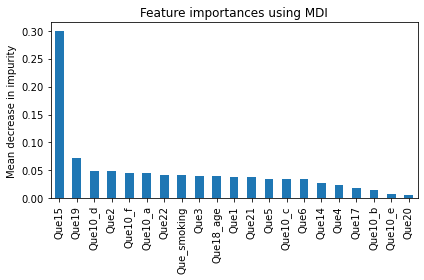

In [44]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:11:43.148962
Mean cross-validation score of best model: 
0.7087
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 43,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 87}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 43,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 87,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6031
Test accuracy:	 0.635
Test precision:	 0.79
Test ROC AUC:	 0.6494
Test F1 score:	 0.684
Test confusion matrix:	
[[ 96  42]
 [104 158]]
Elapsed time to compute the importances: 0.781 se

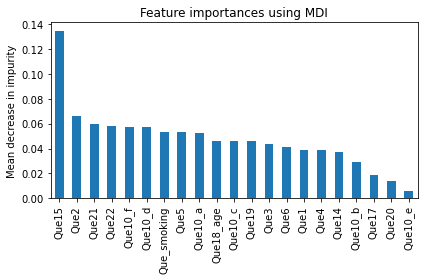

In [45]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:17:37.309221
Mean cross-validation score of best model: 
0.6215
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7061
Test accuracy:	 0.6275
Test precision:	 0.7198
Test ROC AUC:	 0.5922
Test F1 score:	 0.7129
Test confusion matrix:	
[[ 66  72]
 [ 77 185]]
Elapsed time to compute the importances: 0.03

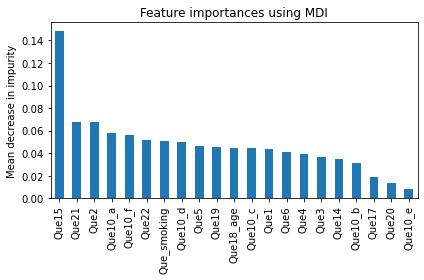

In [46]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:12:38.048116
Mean cross-validation score of best model: 
0.8484
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 87}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 87,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 87,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.584
Test accuracy:	 0.65
Test precision:	 0.8315
Test ROC AUC:	 0.6797
Test F1 score:	 0.6861
Test confusion matrix:	
[[107  31]
 [109 153]]
Elapsed time to compute the importances: 0.735 s

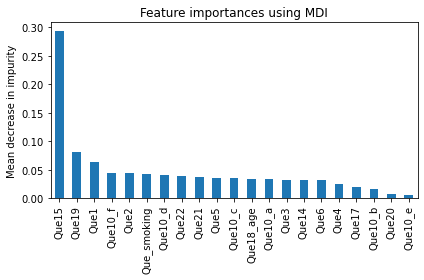

In [47]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [48]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.472345
Mean cross-validation score of best model: 
0.7812
Best parameters:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7748
Test accuracy:	 0.66
Test precision:	 0.725
Test ROC AUC:	 0.6084
Test F1 score:	 0.7491
Test confusion matrix:	
[[ 61  77]
 [ 59 203]]


### Undersampling

In [49]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:01.852514
Mean cross-validation score of best model: 
0.6563
Best parameters:
{'criterion': 'gini',
 'max_depth': 34,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 34,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5458
Test accuracy:	 0.5925
Test precision:	 0.7647
Test ROC AUC:	 0.6135
Test F1 score:	 0.637
Test confusion matrix:	
[[ 94  44]
 [119 143]]


### Oversampling

In [50]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.832213
Mean cross-validation score of best model: 
0.6041
Best parameters:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5878
Test accuracy:	 0.6125
Test precision:	 0.7662
Test ROC AUC:	 0.6236
Test F1 score:	 0.6652
Test confusion matrix:	
[[ 91  47]
 [108 154]]


### SMOTEENN

In [51]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:01.985295
Mean cross-validation score of best model: 
0.819
Best parameters:
{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.626
Test accuracy:	 0.64
Test precision:	 0.781
Test ROC AUC:	 0.6463
Test F1 score:	 0.6949
Test confusion matrix:	
[[ 92  46]
 [ 98 164]]


# Strategy 4 - most frequent

In [52]:
X_train = data_most_frequent.drop(columns=['Que16']).to_numpy()
y_train = data_most_frequent['Que16'].to_numpy()
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [53]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8496
Optimization terminated successfully.
         Current function value: 0.574917
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3910
Model:                          Logit   Df Residuals:                     3888
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                 0.07437
Time:                        02:42:27   Log-Likelihood:                -2247.9
converged:                       True   LL-Null:                       -2428.5
Covariance Type:            nonrobust   LLR p-value:                 9.247e-64
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5723      0.127     -4.511      0.000      -0.821  

### Undersampling

In [54]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6285
Optimization terminated successfully.
         Current function value: 0.640034
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2444
Model:                          Logit   Df Residuals:                     2422
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                 0.07663
Time:                        02:42:27   Log-Likelihood:                -1564.2
converged:                       True   LL-Null:                       -1694.1
Covariance Type:            nonrobust   LLR p-value:                 4.781e-43
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2919      0.155     -8.343      0.000      -1.595  

### Oversampling

In [55]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.4229
Optimization terminated successfully.
         Current function value: 0.637117
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 5376
Model:                          Logit   Df Residuals:                     5354
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                 0.08083
Time:                        02:42:27   Log-Likelihood:                -3425.1
converged:                       True   LL-Null:                       -3726.4
Covariance Type:            nonrobust   LLR p-value:                4.922e-114
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.3292      0.105    -12.615      0.000      -1.536  

### SMOTEENN

In [56]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.4038
Optimization terminated successfully.
         Current function value: 0.482752
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2680
Model:                          Logit   Df Residuals:                     2658
Method:                           MLE   Df Model:                           21
Date:                Fri, 03 Sep 2021   Pseudo R-squ.:                  0.2830
Time:                        02:42:28   Log-Likelihood:                -1293.8
converged:                       True   LL-Null:                       -1804.5
Covariance Type:            nonrobust   LLR p-value:                7.693e-203
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.9402      0.220    -17.900      0.000      -4.372  

## Random Forest

### No balance

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:12:06.387754
Mean cross-validation score of best model: 
0.8121
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 54,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 54,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5878
Test accuracy:	 0.6
Test precision:	 0.7476
Test ROC AUC:	 0.6055
Test F1 score:	 0.6581
Test confusion matrix:	
[[ 86  52]
 [108 154]]
Elapsed time to compute the importances: 0.026 s

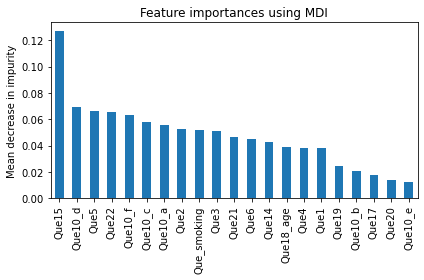

In [57]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:11:42.188777
Mean cross-validation score of best model: 
0.6825
Best parameters:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 15}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6107
Test accuracy:	 0.635
Test precision:	 0.7843
Test ROC AUC:	 0.6459
Test F1 score:	 0.6867
Test confusion matrix:	
[[ 94  44]
 [102 160]]
Elapsed time to compute the importances:

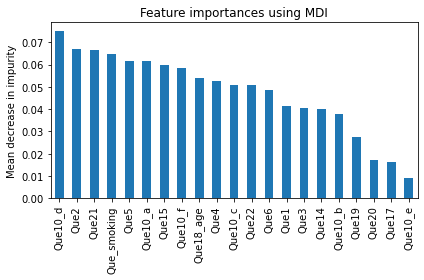

In [58]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:17:36.425929
Mean cross-validation score of best model: 
0.5479
Best parameters:
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.7634
Test accuracy:	 0.6675
Test precision:	 0.738
Test ROC AUC:	 0.6244
Test F1 score:	 0.7505
Test confusion matrix:	
[[ 67  71]
 [ 62 200]]
Elapsed time to compute the importances: 0

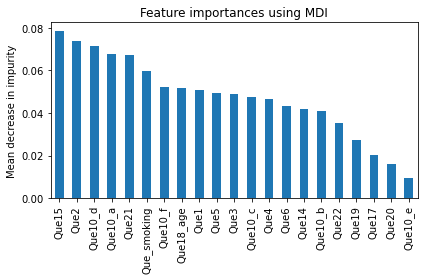

In [59]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 2970 candidates, totalling 14850 fits
Grid search time: 0:14:36.402173
Mean cross-validation score of best model: 
0.9159
Best parameters:
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 67}
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 67,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.916
Test accuracy:	 0.6775
Test precision:	 0.6916
Test ROC AUC:	 0.5703
Test F1 score:	 0.7882
Test confusion matrix:	
[[ 31 107]
 [ 22 240]]
Elapsed time to compute the importances:

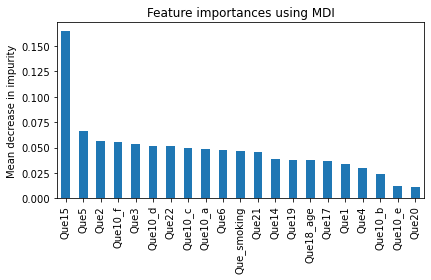

In [60]:
perform_random_forest(X_train, y_train, X_test, y_test)

## Decision Tree

### No balance

In [61]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.489454
Mean cross-validation score of best model: 
0.8181
Best parameters:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.8244
Test accuracy:	 0.68
Test precision:	 0.7248
Test ROC AUC:	 0.6151
Test F1 score:	 0.7714
Test confusion matrix:	
[[ 56  82]
 [ 46 216]]


### Undersampling

In [62]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:01.847560
Mean cross-validation score of best model: 
0.6571
Best parameters:
{'criterion': 'gini',
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 26,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5916
Test accuracy:	 0.5975
Test precision:	 0.7416
Test ROC AUC:	 0.6001
Test F1 score:	 0.6582
Test confusion matrix:	
[[ 84  54]
 [107 155]]


### Oversampling

In [63]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.859204
Mean cross-validation score of best model: 
0.5416
Best parameters:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'splitter': 'random'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.6031
Test accuracy:	 0.62
Test precision:	 0.767
Test ROC AUC:	 0.6276
Test F1 score:	 0.6752
Test confusion matrix:	
[[ 90  48]
 [104 158]]


### SMOTEENN

In [64]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid search time: 0:00:02.000742
Mean cross-validation score of best model: 
0.7925
Best parameters:
{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
(array([0., 1.]), array([138, 262]))
Test recall:	 0.5344
Test accuracy:	 0.585
Test precision:	 0.7609
Test ROC AUC:	 0.6078
Test F1 score:	 0.6278
Test confusion matrix:	
[[ 94  44]
 [122 140]]
